# WOE and SHAP Experiments

Author: https://www.github.com/deburky

In [1]:
from pathlib import Path

import catboost as cb
import numpy as np
import pandas as pd
from fastwoe import FastWoe
from fisher_scoring import LogisticRegression
from matplotlib import pyplot as plt
from pygam import LinearGAM, s
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures, TargetEncoder

In [2]:
# Set the path to the data directory
data_dir = Path.cwd().parent / "data"

# Load the data
df = pd.read_csv(data_dir / "BankCaseStudyData.csv")

# Define the features and label
features = [
    "Application_Score",
    "Bureau_Score",
    "Number_of_Payments",
]

label = "Final_Decision"

X = df[features]
y = df[label].map({"Accept": 0, "Decline": 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = Pipeline(
    [
        (
            "woe",
            FastWoe(
                binning_method="tree",
                tree_kwargs={"max_depth": 2, "min_samples_leaf": 5},
            ),
        ),
        ("logistic_regression", LogisticRegression()),
    ]
)

pipeline.fit(X_train, y_train)
pipeline[-1].display_summary(style="cyan1")

╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 8 │
│         Log Likelihood: -3452.0306         │
│         Beta 0 = intercept (bias): True    │
│                                            │
╰────────────────────────────────────────────╯

                          Fisher Scoring Logistic Regression Summary                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃          Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│   intercept (bias) │ -5.9826  │ 0.0874     │ -68.4229       │ 0.0000  │ -6.1539  │ -5.8112  │
│  Application_Score │ 1.1396   │ 0.0457     │ 24.9256        │ 0.0000  │ 1.0500   │ 1.2292   │
│       Bureau_Score │ 0.9549   │ 0.0523     │ 18.2477        │ 0.0000  │ 0.8523   │ 1.0575   │
│ Number_of_Payments │ 0.4460   │ 0.0244     │ 18.3097        │ 0.0000  │ 0.3983   │ 0.4937   │
└────────────────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

## Experiment 1: Baking Intercept into WOE

WOE is a centered log-odds per bin. Therefore, if we want to fit logistic regression without intercept but still retain calibration, we can bake in the log-odds into the WOE scores.

The transformation is simple:

$$
\text{logit}(p_i) = \text{logit}(p) + \sum_{j=1}^d WOE_{ij}
$$

The we can fit a logistic regression without intercept:

$$
\text{logit}(p_i) = \sum_{j=1}^d \beta_j WOE_{ij}
$$



In [3]:
woe_transformer = FastWoe(
    binning_method="tree",
    tree_kwargs={"max_depth": 2, "min_samples_leaf": 5},
)
woe_transformer.fit(X_train, y_train)

X_train_woe = woe_transformer.transform(X_train)
X_test_woe = woe_transformer.transform(X_test)

log_odds = np.log(y_train.mean()) - np.log(1 - y_train.mean())
print(f"Log odds: {log_odds:.2f}")

# Bake in log odds into WOE scores
X_train_log_odds = X_train_woe + log_odds

# Fit LR
USE_BIAS = False
lr_model_no_bias = LogisticRegression(use_bias=USE_BIAS)
lr_model_no_bias.fit(X_train_log_odds, y_train)
lr_model_no_bias.display_summary(style="cyan1")

# Compare probabilities
y_pred = lr_model_no_bias.predict_proba(X_train_log_odds)[:, 1]
print(round(y_pred.mean(), 4), round(y_train.mean(), 4))

Log odds: -2.15


╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 8 │
│         Log Likelihood: -3543.3946         │
│         Beta 0 = intercept (bias): False   │
│                                            │
╰────────────────────────────────────────────╯

                          Fisher Scoring Logistic Regression Summary                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃          Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│  Application_Score │ 1.2187   │ 0.0424     │ 28.7673        │ 0.0000  │ 1.1357   │ 1.3018   │
│       Bureau_Score │ 1.0182   │ 0.0503     │ 20.2286        │ 0.0000  │ 0.9196   │ 1.1169   │
│ Number_of_Payments │ 0.6205   │ 0.0209     │ 29.7298        │ 0.0000  │ 0.5796   │ 0.6614   │
└────────────────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

0.1217 0.1045


## Experiment 2: SHAP Logistic Regression

Here we use SHAP values as features in the logistic regression.

In [4]:
cb_model = cb.CatBoostClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    allow_writing_files=False,
    verbose=False,
)

train_pool = cb.Pool(X_train, y_train)
test_pool = cb.Pool(X_test)

cb_model.fit(train_pool)

shap_values = cb_model.get_feature_importance(
    type="ShapValues",
    data=train_pool,
)

preds = cb_model.predict_proba(X_test)[:, 1]
gini_score = roc_auc_score(y_test, preds) * 2 - 1
print(f"Gini score CatBoost: {gini_score:.4f}")

# Create SHAP df dropping last column (bias)
shap_values_df = pd.DataFrame(
    shap_values[:, :-1], index=X_train.index, columns=X_train.columns
)

lr_shap = LogisticRegression(use_bias=True)
lr_shap.fit(shap_values_df, y_train)
lr_shap.display_summary(style="cyan1")

y_pred = lr_shap.predict_proba(shap_values_df)[:, 1]
print(round(y_pred.mean(), 4), round(y_train.mean(), 4))

gini_score = roc_auc_score(y_test, preds) * 2 - 1
print(f"Gini score SHAP Logistic Regression: {gini_score:.4f}")

Gini score CatBoost: 0.8964


╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 8 │
│         Log Likelihood: -3277.3460         │
│         Beta 0 = intercept (bias): True    │
│                                            │
╰────────────────────────────────────────────╯

                          Fisher Scoring Logistic Regression Summary                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃          Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│   intercept (bias) │ -3.1487  │ 0.0432     │ -72.9375       │ 0.0000  │ -3.2333  │ -3.0641  │
│  Application_Score │ 2.5851   │ 0.1758     │ 14.7087        │ 0.0000  │ 2.2406   │ 2.9296   │
│       Bureau_Score │ 2.8374   │ 0.1710     │ 16.5966        │ 0.0000  │ 2.5024   │ 3.1725   │
│ Number_of_Payments │ 3.3534   │ 0.1195     │ 28.0668        │ 0.0000  │ 3.1192   │ 3.5875   │
└────────────────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

0.1045 0.1045
Gini score SHAP Logistic Regression: 0.8964


## Experiment 3: SHAP Distillation: Binning vs. GAM

We approximate the **teacher model** (CatBoost) with a simpler **student**  
(Logistic Regression) by mapping raw features into SHAP-derived features.

### Teacher
CatBoost learns a nonlinear function
$$
p_i^{\text{teacher}} = \sigma(f(x_i)),
$$
with SHAP decomposition
$$
f(x_i) \approx \phi_0 + \sum_{j=1}^d \phi_{ij}.
$$

### Student A: SHAP-Binned LR
1. Bin raw features into intervals.  
2. Replace each raw $x_{ij}$ by its average SHAP contribution $\tilde{\phi}_{ij}$.  
3. Optionally add interaction terms $\tilde{\phi}_{ij}\tilde{\phi}_{ik}$.  
4. Fit logistic regression:
$$
\hat{p}_i = \sigma\!\Big(\beta_0 + \sum_j \beta_j \tilde{\phi}_{ij} 
+ \sum_{j<k} \beta_{jk}\tilde{\phi}_{ij}\tilde{\phi}_{ik}\Big).
$$

### Student B: SHAP-GAM LR
1. Fit a **GAM** $g_j$ such that $g_j(x_{ij}) \approx \phi_{ij}$.  
2. Transform raw inputs via GAM predictions.  
3. Expand with polynomial interactions.  
4. Fit logistic regression on GAM-mapped SHAP features.

Both students yield **linear, interpretable scorecards** that approximate  
the teacher while preserving much of its predictive power.


### Student A: SHAP-Binned LR

We distill a **teacher** (CatBoost) into a simpler **student** (Logistic Regression) using SHAP-based features.

CatBoost produces SHAP values
$$
f(x_i) \;\approx\; \phi_0 + \sum_{j=1}^d \phi_{ij},
$$
where $\phi_{ij}$ is the contribution of feature $j$.

### Student
1. **Bin raw features** → map bins to average SHAP contributions $\tilde{\phi}_{ij}$.  
2. Optionally add interaction terms $\tilde{\phi}_{ij}\tilde{\phi}_{ik}$.  

The student is then a logistic regression:
$$
\hat{p}_i = \sigma\!\left(\beta_0 + \sum_j \beta_j \tilde{\phi}_{ij}
+ \sum_{j<k} \beta_{jk}\tilde{\phi}_{ij}\tilde{\phi}_{ik}\right).
$$

This keeps much of the teacher’s predictive power while remaining interpretable and deployable.

In [5]:
def gini_score(y_true, y_prob):
    """Calculate the Gini score."""
    return 2 * roc_auc_score(y_true, y_prob) - 1


class ShapTargetEncoder(BaseEstimator, TransformerMixin):
    """TargetEncoder applied per column using SHAP values as target."""

    def __init__(self, smooth=1e-4):
        self.smooth = smooth
        self.encoders = None

    def fit(self, X, y):
        """Fit the target encoder to the given data."""
        X = np.asarray(X)
        y = np.asarray(y)
        self.encoders = []

        for i in range(X.shape[1]):
            enc = TargetEncoder(smooth=self.smooth)
            enc.fit(X[:, [i]], y[:, i])
            self.encoders.append(enc)

        return self

    def transform(self, X):
        """Transform the given data using the target encoder."""
        X = np.asarray(X)
        return np.column_stack(
            [self.encoders[i].transform(X[:, [i]]) for i in range(X.shape[1])]
        )


class TeacherStudentPipeline(BaseEstimator):
    """SHAP-distilled Student Logistic Regression Model."""

    def __init__(self, n_bins=30, include_interactions=True, smooth=1e-4):
        self.n_bins = n_bins
        self.include_interactions = include_interactions
        self.smooth = smooth

    def fit(self, X, y):
        """Fit the model to the given data."""
        X = pd.DataFrame(X)

        # Teacher fit
        self.teacher = cb.CatBoostClassifier(
            n_estimators=100,
            learning_rate=0.01,
            max_depth=6,
            allow_writing_files=False,
            verbose=False,
        )
        self.teacher.fit(cb.Pool(X, y))

        shap_vals = self.teacher.get_feature_importance(
            type="ShapValues", data=cb.Pool(X, y)
        )[:, :-1]

        # Preprocessor: bin + shap-encoding + optional interactions
        self.binner = KBinsDiscretizer(
            n_bins=self.n_bins, encode="ordinal", strategy="uniform"
        )
        X_binned = self.binner.fit_transform(X)

        self.shap_encoder = ShapTargetEncoder(smooth=self.smooth)
        X_shap_encoded = self.shap_encoder.fit_transform(X_binned, shap_vals)

        if self.include_interactions:
            self.poly = PolynomialFeatures(interaction_only=True, include_bias=False)
            X_proc = self.poly.fit_transform(X_shap_encoded)
        else:
            self.poly = None
            X_proc = X_shap_encoded

        self.student = LogisticRegression(max_iter=1000)
        self.student.fit(X_proc, y)

        return self

    def _transform(self, X):
        """Transform the given data using the target encoder."""
        X_binned = self.binner.transform(X)
        X_shap = self.shap_encoder.transform(X_binned)

        return self.poly.transform(X_shap) if self.poly is not None else X_shap

    def predict_proba(self, X):
        """Predict the probability of the positive class."""
        return self.student.predict_proba(self._transform(X))

    def predict(self, X):
        """Predict the class of the given data."""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

    def score(self, X, y):
        """Score the model on the given data."""
        return gini_score(y, self.predict_proba(X)[:, 1])


# Evaluate on fresh sample
X_new = X_test.sample(100, random_state=42)
y_new = y_test.loc[X_new.index]

# Train both models
models = {
    "interactions": TeacherStudentPipeline(n_bins=30, include_interactions=True),
    "no_interactions": TeacherStudentPipeline(n_bins=30, include_interactions=False),
}

performance = {}
for name, model in models.items():
    model.fit(X_train, y_train)

    performance[f"shap_binned_{name}_train_gini"] = model.score(X_train, y_train)
    performance[f"shap_binned_{name}_test_gini"] = model.score(X_test, y_test)
    performance[f"shap_binned_{name}_gini_new"] = gini_score(
        y_new, model.predict_proba(X_new)[:, 1]
    )

# Print performance metrics
print("\n".join([f"{k}: {v:.4f}" for k, v in performance.items()]))

shap_binned_interactions_train_gini: 0.8645
shap_binned_interactions_test_gini: 0.8732
shap_binned_interactions_gini_new: 0.8800
shap_binned_no_interactions_train_gini: 0.8611
shap_binned_no_interactions_test_gini: 0.8686
shap_binned_no_interactions_gini_new: 0.8889


### Student B: SHAP-GAM LR

We approximate a complex teacher (CatBoost) using a student logistic model built on
SHAP-like features. CatBoost logits decompose as

$$
\text{logit}(p_i) = \phi_0 + \sum_{j=1}^d \phi_{ij}
$$

where $\phi_{ij}$ are SHAP contributions. We fit smooth GAM functions
$g_j(x_{ij}) \approx \phi_{ij}$ to map raw inputs → SHAP-like effects.

To recover lost interactions, we expand these GAM features with pairwise products:

$$
z_i = [g_1(x_{i1}), \dots, g_d(x_{id}), \; g_j(x_{ij}) g_k(x_{ik})]
$$

and train a logistic regression:

$$
\hat{p}_i = \sigma\!\left(\beta_0 + \sum_j \beta_j g_j(x_{ij}) + \sum_{j<k} \beta_{jk} g_j(x_{ij}) g_k(x_{ik})\right)
$$

This student closely matches teacher Gini while remaining interpretable and deployable.

In [6]:
def gini_score(y_true, y_prob):
    """Gini score for binary classification."""
    return 2 * roc_auc_score(y_true, y_prob) - 1


class ShapGAMTransformer(BaseEstimator, TransformerMixin):
    """GAM transformer that fits each feature to its SHAP values."""

    def __init__(self, n_splines=50):
        self.n_splines = n_splines
        self.gam_mappers = {}
        self.feature_names_ = None

    def fit(self, X, y):
        """Fit GAM for each feature using its SHAP values."""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y_arr = np.asarray(y)

        # Ensure y is 2D
        if y_arr.ndim == 1:
            y_arr = y_arr.reshape(-1, 1)

        self.feature_names_ = X_df.columns

        for i, col in enumerate(X_df.columns):
            gam = LinearGAM(s(0, n_splines=self.n_splines))
            gam.fit(X_df[[col]].values, y_arr[:, i])
            self.gam_mappers[col] = gam

        return self

    def transform(self, X):
        """Transform features using fitted GAMs."""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return np.column_stack(
            [
                self.gam_mappers[col].predict(X_df[[col]].values)
                for col in self.feature_names_
            ]
        )


class GAMTeacherStudentPipeline(BaseEstimator):
    """Teacher-Student pipeline using GAM for SHAP distillation."""

    def __init__(self, n_splines=50, include_interactions=True, include_bias=False):
        self.n_splines = n_splines
        self.include_interactions = include_interactions
        self.include_bias = include_bias
        self.teacher = None
        self.student = None

    def fit(self, X, y):
        # Train teacher
        self.teacher = cb.CatBoostClassifier(
            n_estimators=100,
            learning_rate=0.01,
            max_depth=6,
            allow_writing_files=False,
            verbose=False,
        )
        self.teacher.fit(cb.Pool(X, y))

        # Get SHAP values
        shap_values = self.teacher.get_feature_importance(
            type="ShapValues", data=cb.Pool(X, y)
        )[:, :-1]

        # Build student pipeline
        steps = [("gam", ShapGAMTransformer(n_splines=self.n_splines))]

        if self.include_interactions:
            steps.append(
                (
                    "poly",
                    PolynomialFeatures(
                        interaction_only=True, include_bias=self.include_bias
                    ),
                )
            )

        steps.append(("logreg", LogisticRegression(max_iter=1000)))

        self.student = Pipeline(steps)

        # Fit transformers manually on SHAP values
        X_binned = X
        for step_name, transformer in self.student.steps[:-1]:
            if step_name == "gam":
                X_binned = transformer.fit_transform(X_binned, shap_values)
            else:
                X_binned = transformer.fit_transform(X_binned)

        # Fit logreg on true target
        self.student.named_steps["logreg"].fit(X_binned, y)

        return self

    def predict_proba(self, X):
        """Predict probabilities of positive class."""
        return self.student.predict_proba(X)

    def predict(self, X):
        """Predict class labels."""
        return self.student.predict(X)

    def score(self, X, y):
        """Score the model on the given data."""
        return gini_score(y, self.predict_proba(X)[:, 1])

In [7]:
# Train both models
models = {
    "gam_interactions": GAMTeacherStudentPipeline(
        n_splines=30, include_interactions=True
    ),
    "gam_no_interactions": GAMTeacherStudentPipeline(
        n_splines=30, include_interactions=False
    ),
}

# Evaluate
X_new = X_test.sample(100, random_state=42)
y_new = y_test.loc[X_new.index]

performance_gam = {}
for name, model in models.items():
    model.fit(X_train, y_train)

    performance[f"shap_{name}_train_gini"] = model.score(X_train, y_train)
    performance[f"shap_{name}_test_gini"] = model.score(X_test, y_test)
    performance[f"shap_{name}_gini_new"] = gini_score(
        y_new, model.predict_proba(X_new)[:, 1]
    )

# Print performance metrics
print("\n".join([f"{k}: {v:.4f}" for k, v in performance.items()]))

# Add Teacher Gini on test set
performance["teacher_test_gini"] = gini_score(
    y_test, model.teacher.predict_proba(X_test)[:, 1]
)

# Print performance metrics
print("\n".join([f"{k}: {v:.4f}" for k, v in performance.items()]))

shap_binned_interactions_train_gini: 0.8645
shap_binned_interactions_test_gini: 0.8732
shap_binned_interactions_gini_new: 0.8800
shap_binned_no_interactions_train_gini: 0.8611
shap_binned_no_interactions_test_gini: 0.8686
shap_binned_no_interactions_gini_new: 0.8889
shap_gam_interactions_train_gini: 0.8825
shap_gam_interactions_test_gini: 0.8963
shap_gam_interactions_gini_new: 0.8800
shap_gam_no_interactions_train_gini: 0.8777
shap_gam_no_interactions_test_gini: 0.8941
shap_gam_no_interactions_gini_new: 0.8667
shap_binned_interactions_train_gini: 0.8645
shap_binned_interactions_test_gini: 0.8732
shap_binned_interactions_gini_new: 0.8800
shap_binned_no_interactions_train_gini: 0.8611
shap_binned_no_interactions_test_gini: 0.8686
shap_binned_no_interactions_gini_new: 0.8889
shap_gam_interactions_train_gini: 0.8825
shap_gam_interactions_test_gini: 0.8963
shap_gam_interactions_gini_new: 0.8800
shap_gam_no_interactions_train_gini: 0.8777
shap_gam_no_interactions_test_gini: 0.8941
shap_gam_n

## Visual comparison of SHAP distillation models

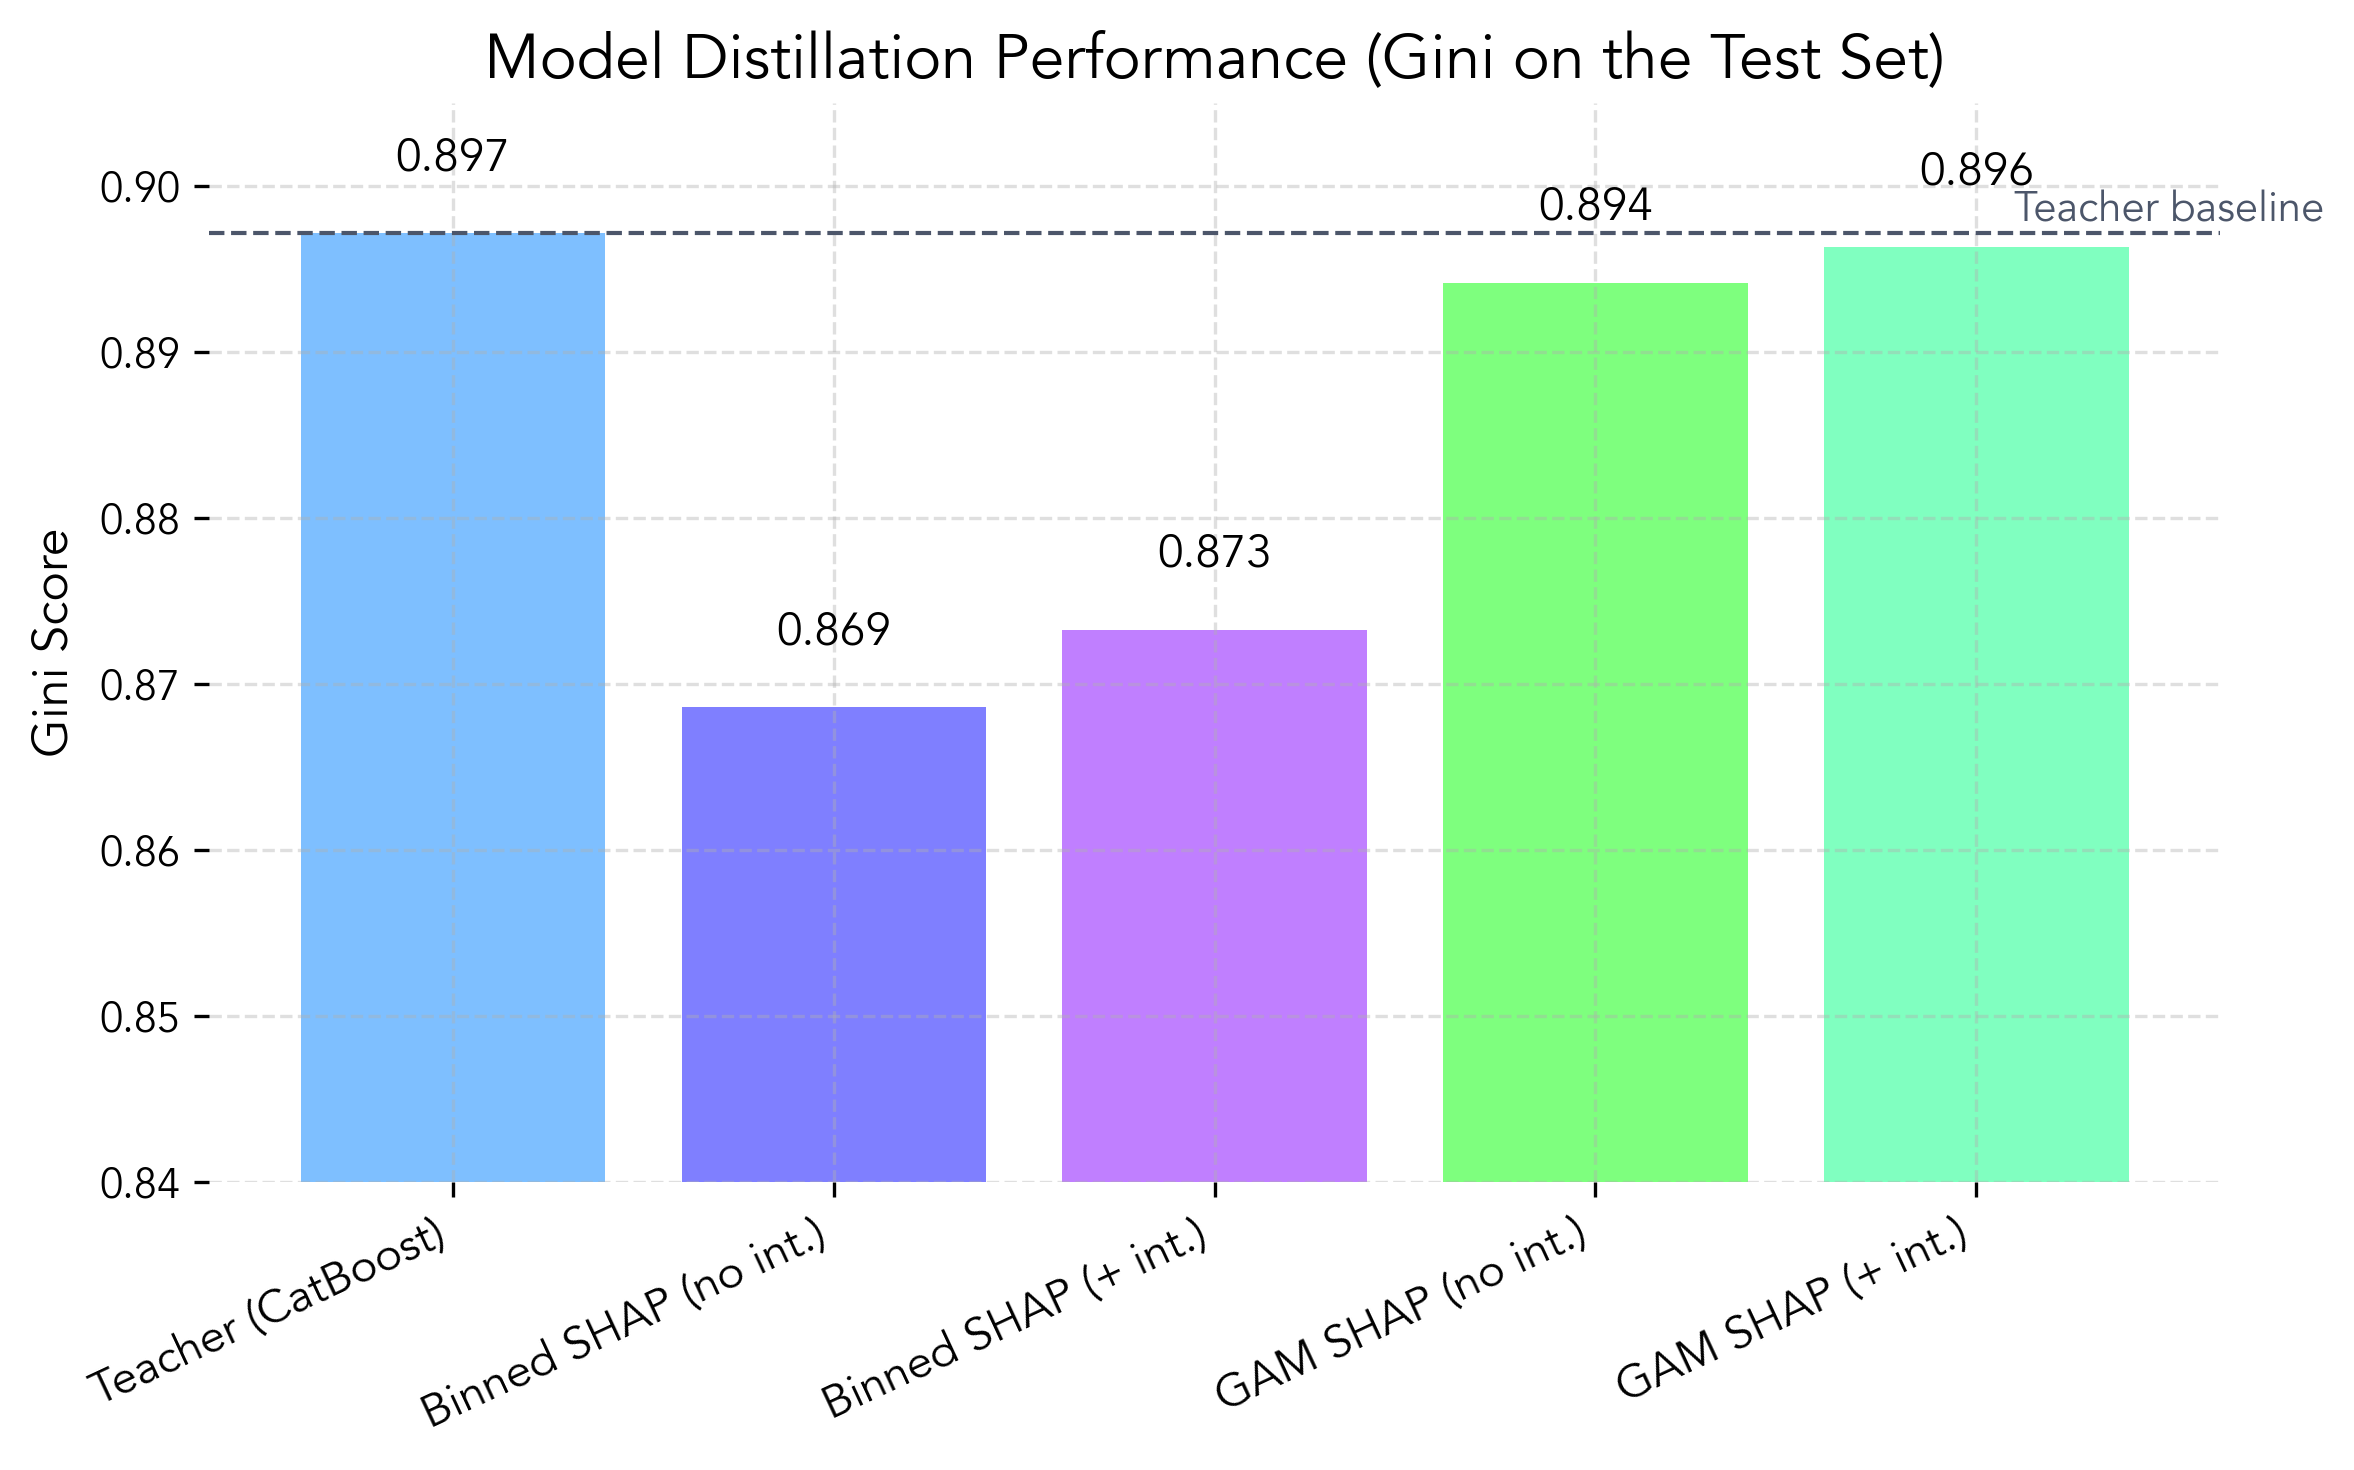

In [8]:
# 1Set Font & Style
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4
plt.rcParams["grid.linestyle"] = "--"

# 2. Gini Scores
teacher_gini = performance["teacher_test_gini"]
binned_no_interactions = performance["shap_binned_no_interactions_test_gini"]
binned_with_interactions = performance["shap_binned_interactions_test_gini"]

gam_no_interactions = performance["shap_gam_no_interactions_test_gini"]
gam_with_interactions = performance["shap_gam_interactions_test_gini"]

models = [
    "Teacher (CatBoost)",
    "Binned SHAP (no int.)",
    "Binned SHAP (+ int.)",
    "GAM SHAP (no int.)",
    "GAM SHAP (+ int.)",
]

gini_scores = [
    teacher_gini,
    binned_no_interactions,
    binned_with_interactions,
    gam_no_interactions,
    gam_with_interactions,
]

colors = [
    "#7ebfff",
    "#7f7fff",
    "#c07fff",
    "#7eff7e",
    "#80ffc0",
    "#7effff",
    "#ff8eff",
    "#ff7ebf",
    "#ff7f80",
]

# 3. Plot Bar Chart
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
bars = ax.bar(models, gini_scores, color=colors, edgecolor="none")

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.003,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="medium",
    )

# 4. Formatting
ax.set_title(
    "Model Distillation Performance (Gini on the Test Set)",
    fontsize=15,
    fontweight="bold",
)
ax.set_ylabel("Gini Score", fontsize=12)
ax.set_ylim(0.84, 0.905)
plt.xticks(rotation=25, ha="right", fontsize=11)

# Reference line for teacher baseline
ax.axhline(teacher_gini, color="#4C566A", linestyle="--", linewidth=1)
ax.text(
    4.1,
    teacher_gini + 0.0007,
    "Teacher baseline",
    fontsize=10,
    color="#4C566A",
    ha="left",
)

plt.tight_layout()
plt.show()
